In [1]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.utils
from torch.utils.data import DataLoader

In [2]:
import cv2
from torchvision.datasets import VOCSegmentation
from torchvision import transforms

cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)


VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]


VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]


class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, image_set, root="~/data/pascal_voc", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask):
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
        for label_index, label in enumerate(VOC_COLORMAP):
            segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
        return segmentation_mask

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

transform = transforms.Compose([
    transforms.ToTensor(),   # Convert to tensor
    transforms.Resize(size=(64,64), antialias=True)
])

train_set = PascalVOCSearchDataset(image_set="train", transform=transform)
val_set = PascalVOCSearchDataset(image_set="val", transform=transform)

Using downloaded and verified file: C:\Users\XPS/data/pascal_voc\VOCtrainval_11-May-2012.tar
Extracting C:\Users\XPS/data/pascal_voc\VOCtrainval_11-May-2012.tar to C:\Users\XPS/data/pascal_voc
Using downloaded and verified file: C:\Users\XPS/data/pascal_voc\VOCtrainval_11-May-2012.tar
Extracting C:\Users\XPS/data/pascal_voc\VOCtrainval_11-May-2012.tar to C:\Users\XPS/data/pascal_voc


In [3]:
dataloaders = {
    'train': DataLoader(train_set, batch_size=32, shuffle=True),
    'val': DataLoader(val_set, batch_size=32, shuffle=True)
}

In [4]:
# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(dataloaders['train'])
images, ilabels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
label_grid = torchvision.utils.make_grid(ilabels)

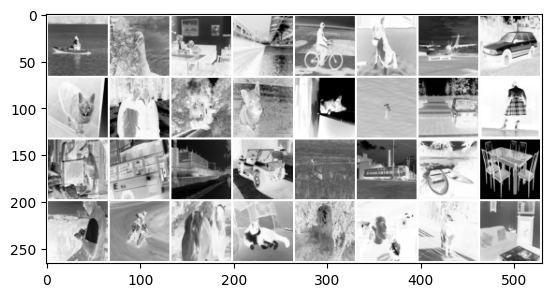

In [5]:
matplotlib_imshow(img_grid, one_channel=True)

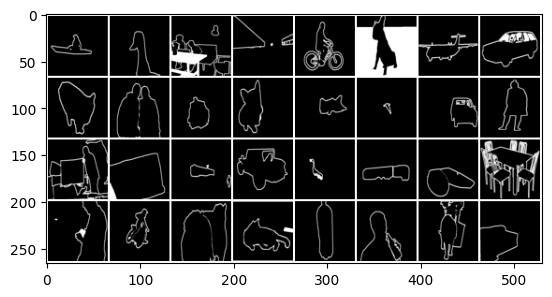

In [6]:
matplotlib_imshow(label_grid, one_channel=True)

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()

        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)
        self.dconv_down5 = DoubleConv(512, 1024)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up4 = DoubleConv(512 + 1024, 512)
        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_class, 1)


    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)

        x = self.dconv_down5(x)

        x = self.upsample(x)
        x = torch.cat([x, conv4], dim=1)

        x = self.dconv_up4(x)
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)

        x = self.dconv_up2(x)
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out
    

def test():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    Net = UNet(21).to(device)

    x = torch.randn(32, 3, 128, 128).to(device)
    y = Net(x)
    print(f'{y.shape}')

test()

torch.Size([32, 21, 128, 128])


In [8]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [9]:
print(torch.cuda.is_available())

True


In [10]:
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

LEARNING_RATE = 1e-4
NUM_EPOCHS = 5

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(21).to(device)

initialize_weights(model)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

train_writer = SummaryWriter('myruns/train')
val_writer = SummaryWriter('myruns/val')

In [11]:
# Train the model
train_batch_idx = 0
val_batch_idx = 0
for epoch in range(NUM_EPOCHS):
    # Train the model for one epoch
    for i, data in enumerate(dataloaders['train']):
        # Get inputs and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        # Update training loss
        train_writer.add_scalar('train_loss', loss.item(), train_batch_idx)
        train_batch_idx += 1
        train_writer.close()
    # print('Done with training')

    # Evaluate the model on the validation set
    for i, data in enumerate(dataloaders['val']):
        # Get inputs and labels
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        with torch.no_grad():
            # Forward pass
            outputs = model(inputs)

            # Calculate loss
            loss = criterion(outputs, labels)

            # Update validation loss
            val_writer.add_scalar('val_loss', loss.item(), val_batch_idx)
            val_writer.close()


        val_batch_idx += 1
    
      
    print(f'Done with epoch {epoch}')

Done with epoch 0
Done with epoch 1
Done with epoch 2
Done with epoch 3
Done with epoch 4


In [12]:
# Saving model
torch.save(model, 'models/mymodel3.pth')

In [13]:
# Saving model weights
torch.save(model.state_dict(), 'models/mymodel3_weights.pth')

Thoughts and things I observed:
This is like the 4th iteration so I am a bit late.
* Adding BatchNorm made the training and validation stable. But in the testing it was still a blank image.
* Putting the DobuleConve in an nn.Module class instead of just a simple def function made the training better. The image in the testing is no more a blank image and shows segmentation. It's not perfect but good enough.

I want to figure out why what happened happened.